# Logisitic regression problem - predicting passenger's survival on Titanic #

Data we have access to: 
- passenger class (Pclass)
- sex 
- age 
- no. of sibling/spouse onboard (SibSp)
- no. of parents/child onboard (Parch)
- Fare
- Cabin
- port of embarkment(embarked)
    - Southhampton(S)
    - Cherbourg (C)
    - Queenstown (Q)

Information of abstraction: 
- Name
- ticket number

In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Empty data handling ##
- dealing with the missing data in the dataset denoted by NaN

- For cabin number, if no value is assigned then we can assume they were not assigned a cabin. 
We can consider a better feature of whether a cabin were assigned or not

- With age, we will have to remove columns without age, as it is a crucial variable in determining survival and we cannot assign a random value to it.

Since we are not handling time series data, forward fill will not be approapriate.

In [267]:
# Using a lambda function to change if assigned a cabin = 1 if not then = 0
# cannot use x == np.NaN cus it will return False even if x is NaN
df_train['Cabin'] = df_train['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
df_train['Cabin'].head()

# then we will remove all rows with NaN - assuming only age is missing for some rows now
df_train.dropna(axis = 0)

# drop name and ticket number
df_train = df_train.drop('Name',axis='columns')
df_train = df_train.drop('Ticket',axis='columns')


# combine the sibSp and Parch column into one 'relative'
df_train['relatives'] = df_train['SibSp'] + df_train['Parch']
df_train = df_train.drop('SibSp',axis='columns')
df_train = df_train.drop('Parch',axis='columns')
df_train.head()
df_train.tail()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,relatives
886,887,0,2,male,27.0,13.00,0,S,0
887,888,1,1,female,19.0,30.00,1,S,0
888,889,0,3,female,NaN,23.45,0,S,3
889,890,1,1,male,26.0,30.00,1,C,0
890,891,0,3,male,32.0,7.75,0,Q,0


### Basic analysis ### 

I want to first consider whether there is any correlation between certain feature and survival, so I will visualise some of these relations to help decide.

In [268]:
def category_plots (df,category):

    grouped = df.groupby(category)['Survived'].mean()
    grouped.plot(kind='bar')
    plt.ylabel('probability of survival')
    plt.title(f'Probability of Survival by {category}')
    plt.show()

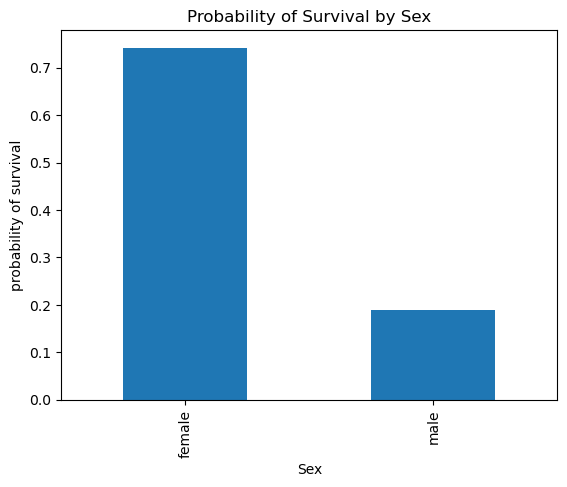

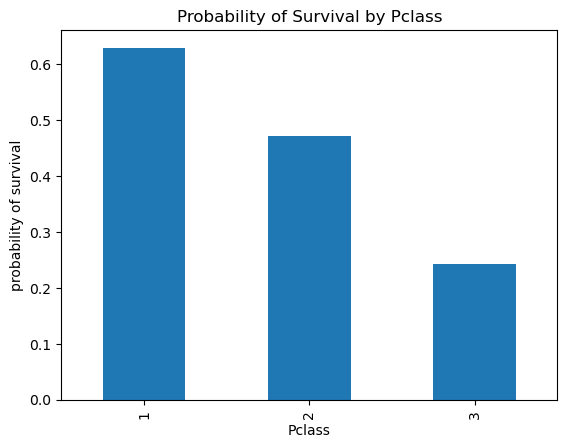

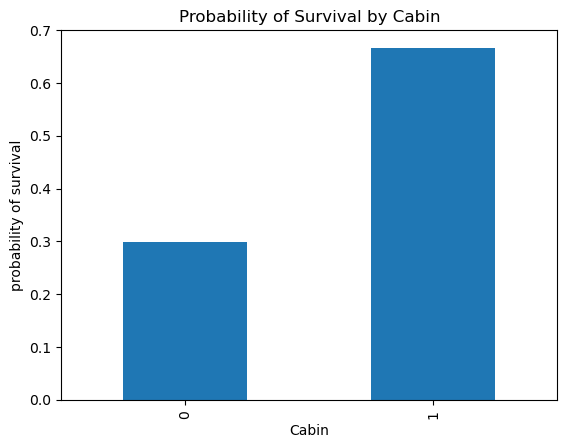

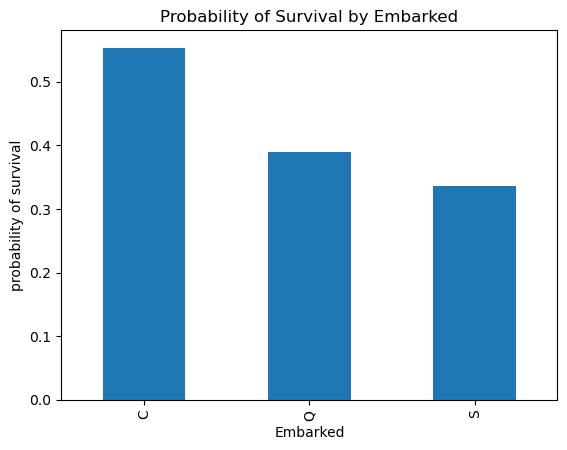

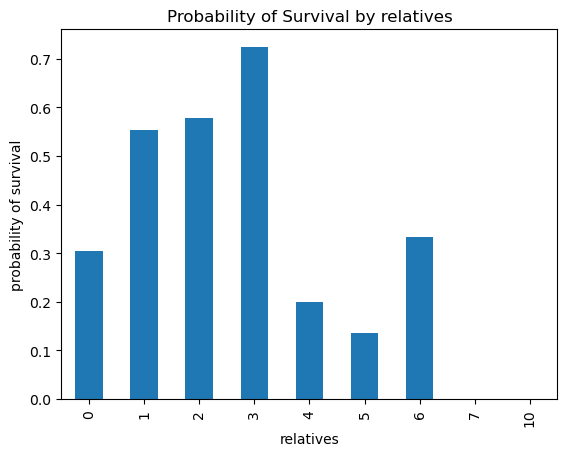

In [269]:
category_plots(df_train,'Sex')
category_plots(df_train,'Pclass')
category_plots(df_train,'Cabin')
category_plots(df_train,'Embarked')
category_plots(df_train,'relatives')

C:\Users\mmc224\AppData\Local\Temp\ipykernel_12300\85185129.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(category)['Survived'].mean()


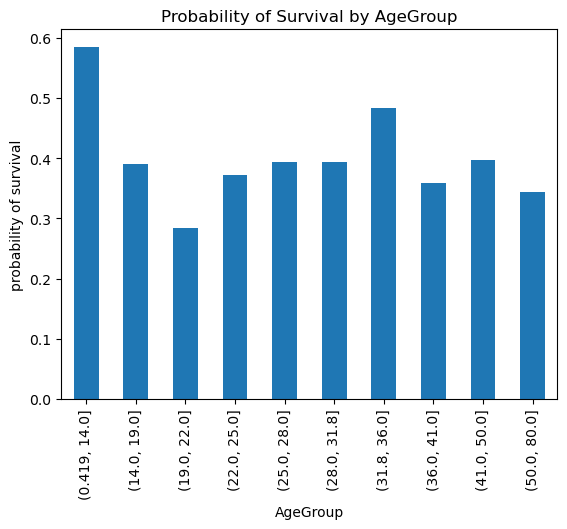

C:\Users\mmc224\AppData\Local\Temp\ipykernel_12300\85185129.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(category)['Survived'].mean()


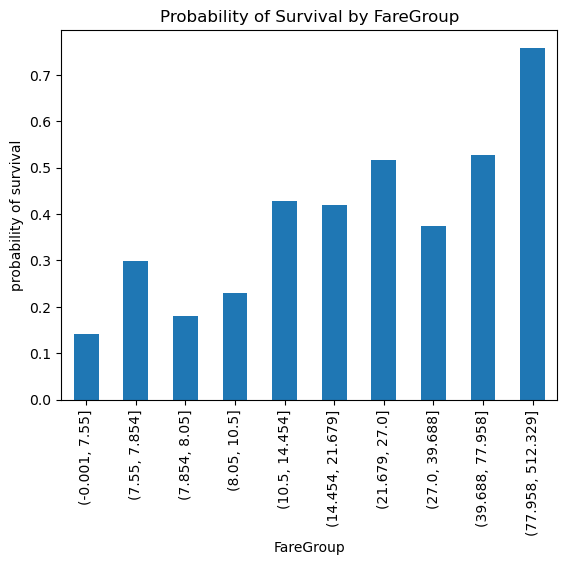

In [270]:
# For age and fare, I will categorise them and then plot the probability of survival in each category onto a bar charts
df_train["AgeGroup"] = pd.qcut(df_train["Age"], 10)
category_plots(df_train,'AgeGroup')
df_train["FareGroup"] = pd.qcut(df_train["Fare"], 10)
category_plots(df_train,'FareGroup')
plt.show()


Conclusion: 

we will attempt to model survival as a logisitic regression using the following features: 

- Sex 
- Pclass 
- Cabin
- Fare
- port of embarkment

My plan will be to use three weights which only not equal to zero for their own value of x. 
C = 3
Q = 2
S = 1
since looking at the preliminary analysis that chances of survival from C is highest followed by Q and S.

- no. of relatives and Age - maybe we will attempt polynomial regression of order less than or equal to 3 before fitting the sigmoid function.

* At this current stage, we will only attempt linear regression

### Logisitic regression ###

- we will first start with building the linear model
- normalise any data that have significantly large magnitude

In [271]:
# convert some of the information in text to number values 
# for sex: male = 0 , female = 1
# for port : C = 3, Q = 2 , Q = 1

df_train.replace(to_replace="male",value=0,inplace=True)
df_train['Sex'].replace(to_replace="female",value=1,inplace=True)
df_train['Embarked'].replace('C',3,inplace=True)
df_train['Embarked'].replace('Q',2,inplace=True)
df_train['Embarked'].replace('S',1,inplace=True)

df_train["Age_normalised"] = df_train["Age"].apply(lambda x: (x - df_train["Age"].mean())/df_train["Age"].std())
df_train["Fare_normalised"] = df_train["Fare"].apply(lambda x: (x - df_train["Fare"].mean())/df_train["Fare"].std())


training_features_linear_only = df_train[["Fare_normalised","Pclass","Sex","Cabin","Embarked"]]
training_features_all = df_train[["Age_normalised","Fare_normalised","Pclass","Sex","Cabin","Embarked","relatives"]]


training_features_linear_only.head()

C:\Users\mmc224\AppData\Local\Temp\ipykernel_12300\3245468107.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Sex'].replace(to_replace="female",value=1,inplace=True)
C:\Users\mmc224\AppData\Local\Temp\ipykernel_12300\3245468107.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tra

,Fare_normalised,Pclass,Sex,Cabin,Embarked
0,-0.502163,3,0,0,1.0
1,0.786404,1,1,1,3.0
2,-0.488580,3,1,0,1.0
3,0.420494,1,1,1,1.0
4,-0.486064,3,0,0,1.0


In [ ]:
# convert the training data into a np matrix


x = training_features_linear_only.to_numpy()


# setting up initial weights

def linear_reg_gradient_descent (x,y,Lr,tolerance):

# obtain the dimensions of the data set
    
    m,n = x.shape
    print("features=",n)
    print("samples=",m)

    # initiate with weights of 1 and b of 0
    w = np.array([1 for _ in range(n)]).astype('float64')
    b = 0

    # predict and calculate the gradients for w, b
    convergence = False
    cycle = 0
    while convergence == False:
        y_predicted = np.zeros(m)
        dJ_dw = np.zeros(n)
        dJ_db = 0

        for i in range (0,m):
            y_predicted[i] = np.dot(w,x[i,:])+b
            for j in range (0,n):
                dJ_dw[j] += (y_predicted[i] - y[i])*x[i,j]
            
            dJ_db += y_predicted[i]- y[i]
            

        # update the weights
        w = w - (Lr/m)*(np.transpose(dJ_dw))
        b = b - (Lr/m)*(dJ_db)
        print("y",y)
        print("model predicted",y_predicted)

        cost = 0
        for i in range(0,m):
            cost += ((y_predicted[i] - y[i])**2)/y[i]
        print("cost",cost)
         
        cycle += 1
        print("cycle no. : ",cycle)

        if cost < 10:
            convergence = True
        else: 
             convergence = False
    return w, b


def sigmoid_function ():
